In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing

import os
for dirname, _, filenames in os.walk('/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Streaming output truncated to the last 5000 lines.
/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/without_mask/without_mask_2219.jpg
/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/without_mask/without_mask_2232.jpg
/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/without_mask/without_mask_2255.jpg
/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/without_mask/without_mask_222.jpg
/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/without_mask/without_mask_2254.jpg
/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/without_mask/without_mask_2228.jpg
/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/without_mask/without_mask_2239.jpg
/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/without_mask/without_mask_2252.jpg
/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/without_mask/without_mask_2261.jpg
/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/without_mask/without_mask_2241.jpg
/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/without_mask/without_mask_2253.jpg
/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data/without_mask/without_mask_2218.jpg
/drive/MyDrive

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D,Dropout, Flatten, Dense, GlobalAveragePooling2D, Input, BatchNormalization, Activation, Add,concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
import os
import cv2
from keras.preprocessing import image
categories = ['with_mask','without_mask']
data = []
for category in categories:
    path = os.path.join('/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data',category)
    label = categories.index(category)
    for file in os.listdir(path):
        img_path = os.path.join(path,file)
        img = cv2.imread(img_path)
        img = cv2.resize(img,(128,128))
        data.append([img,label])

In [ ]:
import random
random.shuffle(data)
image_data = []
y = []
for features,label in data:
    image_data.append(features)
    y.append(label)

image_data = np.array(image_data)
y = np.array(y)
image_data=preprocess_input(image_data)
print(image_data.shape)
print(y.shape)

(7553, 128, 128, 3)
(7553,)


In [ ]:
def inception_module(x, filters):
    conv1x1_1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    conv1x1_3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv1x1_3)

    conv1x1_5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv1x1_5)

    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_pool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    inception_block = concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_pool], axis=-1)
    return inception_block

In [ ]:
def create_inception_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Stem
    stem = Conv2D(64, (7, 7), padding='same', strides=2, activation='relu')(input_layer)
    stem = MaxPooling2D((3, 3), padding='same', strides=2)(stem)
    stem = BatchNormalization()(stem)
    stem = Conv2D(64, (1, 1), activation='relu')(stem)
    stem = Conv2D(192, (3, 3), activation='relu')(stem)
    stem = BatchNormalization()(stem)
    stem = MaxPooling2D((3, 3), padding='same', strides=2)(stem)

    # Inception blocks
    inception1 = inception_module(stem, [64, 128, 32, 32, 96, 16])
    inception2 = inception_module(inception1, [128, 192, 96, 64, 128, 32])
    inception2 = MaxPooling2D((3, 3), padding='same', strides=2)(inception2)

    inception3 = inception_module(inception2, [192, 208, 48, 64, 96, 16])
    inception4 = inception_module(inception3, [160, 224, 64, 64, 112, 24])
    inception5 = inception_module(inception4, [128, 256, 64, 64, 128, 24])
    inception6 = inception_module(inception5, [112, 288, 64, 64, 144, 32])
    inception7 = inception_module(inception6, [256, 320, 128, 128, 160, 32])
    inception7 = MaxPooling2D((3, 3), padding='same', strides=2)(inception7)

    inception8 = inception_module(inception7, [256, 320, 128, 128, 160, 32])
    inception9 = inception_module(inception8, [384, 384, 128, 128, 192, 48])

    global_avg_pooling = GlobalAveragePooling2D()(inception9)
    dropout = Dropout(0.4)(global_avg_pooling)


    # Fully connected layers
    dense = Dense(1000, activation='relu')(dropout)
    output_layer = Dense(num_classes, activation='softmax')(dense)

    # Model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
# Example usage:
input_shape = (128, 128, 3)
num_classes = 3  # Number of output classes
inception_model = create_inception_model(input_shape, num_classes)

# Display the model summary
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['max_pooling2d[0][0]']   

In [ ]:
inception_model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
    )

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X is your feature matrix and y is the target variable
X_train, X_test, y_train, y_test = train_test_split(image_data, y, test_size=0.2, random_state=42)

In [ ]:
history = inception_model.fit(X_train, y_train,epochs =10 ,batch_size= 128, validation_data=(X_test,y_test))

Epoch 1/10
48/48 [==============================] - 673s 14s/step - loss: 0.5629 - accuracy: 0.7375 - val_loss: 0.6332 - val_accuracy: 0.7081
Epoch 2/10
48/48 [==============================] - 647s 13s/step - loss: 0.2397 - accuracy: 0.9098 - val_loss: 0.5420 - val_accuracy: 0.7300
Epoch 3/10
48/48 [==============================] - 638s 13s/step - loss: 0.2767 - accuracy: 0.8995 - val_loss: 0.2982 - val_accuracy: 0.9073
Epoch 4/10
48/48 [==============================] - 646s 13s/step - loss: 0.1302 - accuracy: 0.9522 - val_loss: 0.2559 - val_accuracy: 0.8915
Epoch 5/10
48/48 [==============================] - 644s 13s/step - loss: 0.0926 - accuracy: 0.9667 - val_loss: 0.2018 - val_accuracy: 0.9292
Epoch 6/10
48/48 [==============================] - 640s 13s/step - loss: 0.0696 - accuracy: 0.9747 - val_loss: 0.1447 - val_accuracy: 0.9457
Epoch 7/10
48/48 [==============================] - 642s 13s/step - loss: 0.0505 - accuracy: 0.9836 - val_loss: 0.1782 - val_accuracy: 0.9259
Epoch 

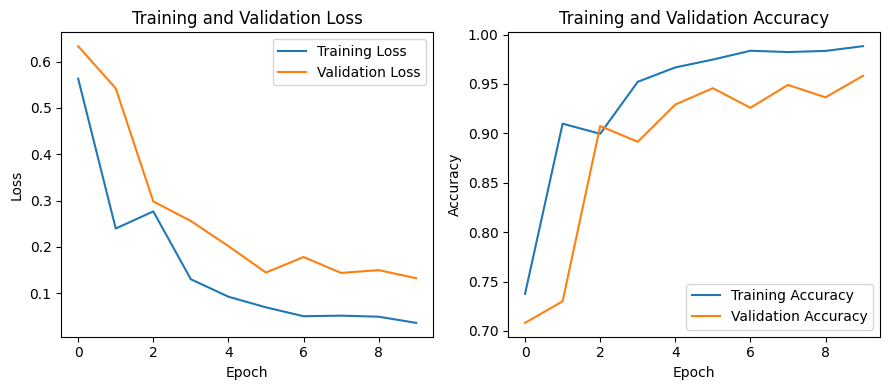

In [ ]:
plt.figure(figsize=(9, 4))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Create the pretrained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = GlobalAveragePooling2D()(base_model.output)

# Fully connected layers
dense = Dense(1000, activation='relu')(x)
predictions = Dense(3, activation='softmax')(dense)
pre_trained_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
pre_trained_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model
histroy = pre_trained_model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test))

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/5
48/48 [==============================] - 1100s 22s/step - loss: 0.1959 - accuracy: 0.9244 - val_loss: 186.4233 - val_accuracy: 0.5043
Epoch 2/5
48/48 [==============================] - 1098s 23s/step - loss: 0.0236 - accuracy: 0.9932 - val_loss: 0.7490 - val_accuracy: 0.8954
Epoch 3/5
48/48 [==============================] - 1130s 24s/step - loss: 0.0298 - accuracy: 0.9924 - val_loss: 156.7793 - val_accuracy: 0.6433
Epoch 4/5
48/48 [==============================] - 1103s 23s/step - loss: 0.0196 - accuracy: 0.9942 - val_loss: 0.3670 - val_accuracy: 0.9146
Epoch 5/5
48/48 [==============================] - 1143s 24s/step - loss: 0.0177 - accuracy: 0.9944 - val_loss: 0.0352 - val_accuracy: 0.9921


In [ ]:
# Display the model summary
pre_trained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 63, 63, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 63, 63, 32)           96        ['conv2d_57[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 63, 63, 32)           0         ['batch_normalization_2[

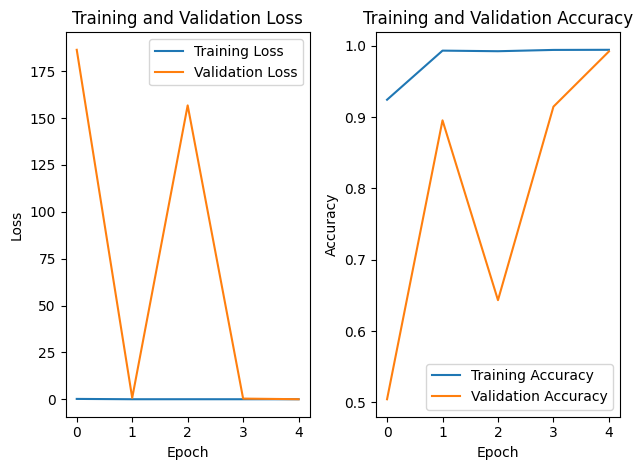

In [ ]:
# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(histroy.history['loss'], label='Training Loss')
plt.plot(histroy.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(histroy.history['accuracy'], label='Training Accuracy')
plt.plot(histroy.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

48/48 [==============================] - 51s 1s/step


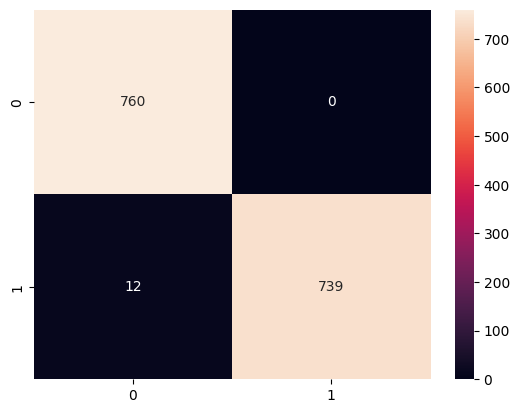

In [ ]:
# prompt: generate confusion matrix

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = pre_trained_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()


In [ ]:
# prompt: print classification report

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=categories))


              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99       760
without_mask       1.00      0.98      0.99       751

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511

